# Facial recognition

## 1. Dependencies and Imports

In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.optim import Optimizer, Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from tqdm import tqdm

In [2]:
import os
from os.path import join
from collections import defaultdict

In [3]:
from PIL import Image
import numpy as np

In [4]:
import matplotlib.pyplot as plt

In [5]:
import json

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 2. Load and preprocess data

In [7]:
BASE_DATASET_PATH = './dataset'
TRAIN_PATH = 'train'
VAL_PATH = 'val'

In [8]:
# Returns a triplet training sample for the model. (ANCHOR, POSITIVE, NEGATIVE)
class TripletDataset(Dataset):
    def __init__(self, root, transform=None):
        self.dataset = ImageFolder(root, transform)
        self.transform = transform
        self.cls_to_idx = defaultdict(list)

        for idx, (_, label) in enumerate(self.dataset.samples):
            self.cls_to_idx[label].append(idx)
        
        self.labels = list(self.cls_to_idx.keys())
    
    def __getitem__(self, index):
        anchor, anchor_label = self.dataset[index]

        # Ensure Positive image is different from Anchor image
        while True:
            positive_index = np.random.choice(self.cls_to_idx[anchor_label])
            if positive_index != index: break

        # Ensure Negative label is different from Anchor label
        while True:
            negative_label = np.random.choice(self.labels)
            if negative_label != anchor_label: break
        
        negative_index = np.random.choice(self.cls_to_idx[negative_label])

        positive, _ = self.dataset[positive_index]
        negative, _ = self.dataset[negative_index]

        return anchor, positive, negative
    
    def __len__(self):
        return len(self.dataset)

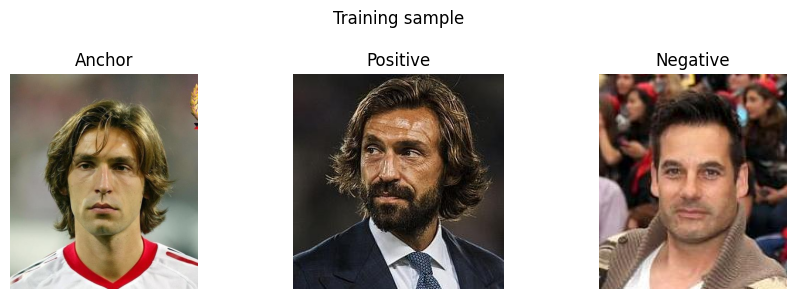

In [9]:
train_ds = TripletDataset(join(BASE_DATASET_PATH, TRAIN_PATH))
batch = train_ds[np.random.randint(0, len(train_ds)-1)]

fig, axes = plt.subplots(1, 3, figsize=(9, 3))
for i, img in enumerate(batch):
    axes[i].imshow(img)
    axes[i].axis(False)

axes[0].set_title('Anchor')
axes[1].set_title('Positive')
axes[2].set_title('Negative')

plt.suptitle('Training sample')
plt.tight_layout()
plt.show()

In [10]:
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.CenterCrop(100),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.CenterCrop(100),
    transforms.ToTensor(),
])

train_ds = TripletDataset(join(BASE_DATASET_PATH, TRAIN_PATH), train_transform)
train_dataloader = DataLoader(train_ds, batch_size=64, shuffle=True)

val_ds = TripletDataset(join(BASE_DATASET_PATH, VAL_PATH), val_transform)
val_dataloader = DataLoader(val_ds, batch_size=64, shuffle=False)

## 3. Building a Siamese Neural Network Model

In [11]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, *, activation=True, use_batchnorm=True):
        super().__init__()
        padding = self.same_padding(kernel_size)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=not use_batchnorm)
        self.bn1 = nn.BatchNorm2d(out_channels) if use_batchnorm else nn.Identity()
        self.activation = activation if isinstance(activation, nn.Module) else nn.ReLU() if activation else nn.Identity()
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=padding)
        self.bn2 = nn.BatchNorm2d(out_channels) if use_batchnorm else nn.Identity()

        if (in_channels != out_channels) or (stride != 1):
            self.residual = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)
        else:
            self.residual = nn.Identity()
    
    def same_padding(self, kernel_size):
        return (kernel_size - 1) // 2
    
    def forward(self, x):
        residual = self.residual(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)

        x = self.conv2(x)
        x = self.bn2(x)

        x = x + residual
        x = self.activation(x)
        return x

In [12]:
class SiameseNetwork(nn.Module):
    def __init__(self, in_channels, embedding_dim):
        super().__init__()

        self.encoder = nn.Sequential(
            ResidualBlock(in_channels, 32, kernel_size=7),
            ResidualBlock(32, 64, kernel_size=5, stride=2),
            ResidualBlock(64, 128, kernel_size=5, stride=2),
            ResidualBlock(128, 256, stride=2),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(256, embedding_dim)
        )

    def forward_once(self, x):
        return self.encoder(x)
    
    def forward(self, anchor, positive, negative):
        z_anchor = self.forward_once(anchor)
        z_positive = self.forward_once(positive)
        z_negative = self.forward_once(negative)
        return z_anchor, z_positive, z_negative

## 4. Training the Model

In [13]:
class TripletLoss(nn.Module):
    def __init__(self, margin, distance_fn):
        super().__init__()
        self.margin = margin
        self.distance_fn = distance_fn

    def forward(self, anchor, positive, negative):
        dist_ap = self.distance_fn(anchor, positive)
        dist_an = self.distance_fn(anchor, negative)

        return torch.mean(F.relu(dist_ap - dist_an + self.margin))

        # dist_pn = self.distance_fn(positive, negative)  
        # return torch.mean(F.relu(dist_ap - dist_an + self.margin) + F.relu(dist_ap - dist_pn + self.margin)) / 2

def cosine_distance(A, B, eps=1e-8):
    sim = F.cosine_similarity(A, B, dim=1, eps=eps)
    return 1 - sim

def euclidean_distance(A, B):
    return torch.norm(A - B, p=2, dim=1)

In [ ]:
def train_step(model: nn.Module, dataloader: DataLoader, criterion: nn.Module, optimizer: Optimizer, device='cuda'):
    model.train()

    total_loss = 0
    total_samples = 0
    progress_bar = tqdm(dataloader, desc='\tTrain')
    for anchor, positive, negative in progress_bar:
        batch_size = anchor.shape[0]

        anchor = anchor.to(device)
        positive = positive.to(device)
        negative = negative.to(device)

        optimizer.zero_grad()

        z_anchor, z_positive, z_negative = model(anchor, positive, negative)
        loss = criterion(z_anchor, z_positive, z_negative)
        
        total_loss += loss.item() * batch_size
        total_samples += batch_size

        loss.backward()
        optimizer.step()

        progress_bar.set_postfix({'loss': total_loss / total_samples})
    
    return total_loss / total_samples

In [15]:
@torch.no_grad()
def eval_step(model: nn.Module, dataloader: DataLoader, criterion: nn.Module, device='cuda'):
    model.eval()

    total_loss = 0
    total_samples = 0
    progress_bar = tqdm(dataloader, desc="\tEval")
    for anchor, positive, negative in progress_bar:
        batch_size = anchor.shape[0]

        anchor = anchor.to(device)
        positive = positive.to(device)
        negative = negative.to(device)

        z_anchor, z_positive, z_negative = model(anchor, positive, negative)
        loss = criterion(z_anchor, z_positive, z_negative)
        
        total_loss += loss.item() * batch_size
        total_samples += batch_size

        progress_bar.set_postfix({'loss': total_loss / total_samples})
    
    return total_loss / total_samples

In [ ]:
EPOCHS = 50

model = SiameseNetwork(3, 512).to('cuda')
criterion = TripletLoss(margin=1.0, distance_fn=euclidean_distance)
optimizer = Adam(model.parameters())

best_val_loss = float('inf')
checkpoint_path = 'mtcnn_recognition_model.pt'
history = defaultdict(list)

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}/{EPOCHS}')
    
    train_loss = train_step(model, train_dataloader, criterion, optimizer, device=device)
    val_loss = eval_step(model, val_dataloader, criterion, device=device)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
        }, checkpoint_path)
        print(f"Saved new best model at epoch {epoch} with val_loss {val_loss:.4f}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}\n")

with open('history.json', 'w') as f:
    json.dump(history, f)

Epoch 1/50


	Eval: 100%|██████████| 333/333 [02:12<00:00,  2.51it/s, loss=0.467]


Saved new best model at epoch 1 with val_loss 0.4671
Train Loss: 0.6324 | Val Loss: 0.4671

Epoch 2/50


	Eval: 100%|██████████| 333/333 [02:08<00:00,  2.59it/s, loss=0.35] 


Saved new best model at epoch 2 with val_loss 0.3501
Train Loss: 0.3980 | Val Loss: 0.3501

Epoch 3/50


	Eval: 100%|██████████| 333/333 [02:07<00:00,  2.61it/s, loss=0.3]  


Saved new best model at epoch 3 with val_loss 0.3001
Train Loss: 0.3056 | Val Loss: 0.3001

Epoch 4/50


	Eval: 100%|██████████| 333/333 [02:08<00:00,  2.60it/s, loss=0.249]


Saved new best model at epoch 4 with val_loss 0.2485
Train Loss: 0.2535 | Val Loss: 0.2485

Epoch 5/50


	Eval: 100%|██████████| 333/333 [02:15<00:00,  2.46it/s, loss=0.239]


Saved new best model at epoch 5 with val_loss 0.2385
Train Loss: 0.2249 | Val Loss: 0.2385

Epoch 6/50


	Eval: 100%|██████████| 333/333 [02:09<00:00,  2.57it/s, loss=0.239]


Train Loss: 0.2037 | Val Loss: 0.2395

Epoch 7/50


	Eval: 100%|██████████| 333/333 [02:08<00:00,  2.60it/s, loss=0.212]


Saved new best model at epoch 7 with val_loss 0.2117
Train Loss: 0.1910 | Val Loss: 0.2117

Epoch 8/50


	Eval: 100%|██████████| 333/333 [02:09<00:00,  2.58it/s, loss=0.223]


Train Loss: 0.1752 | Val Loss: 0.2233

Epoch 9/50


	Eval: 100%|██████████| 333/333 [02:08<00:00,  2.60it/s, loss=0.204]


Saved new best model at epoch 9 with val_loss 0.2042
Train Loss: 0.1666 | Val Loss: 0.2042

Epoch 10/50


	Eval: 100%|██████████| 333/333 [02:08<00:00,  2.59it/s, loss=0.199]


Saved new best model at epoch 10 with val_loss 0.1986
Train Loss: 0.1569 | Val Loss: 0.1986

Epoch 11/50


	Eval: 100%|██████████| 333/333 [02:08<00:00,  2.58it/s, loss=0.208]


Train Loss: 0.1498 | Val Loss: 0.2084

Epoch 12/50


	Eval: 100%|██████████| 333/333 [02:08<00:00,  2.60it/s, loss=0.177]


Saved new best model at epoch 12 with val_loss 0.1771
Train Loss: 0.1425 | Val Loss: 0.1771

Epoch 13/50


	Eval: 100%|██████████| 333/333 [02:07<00:00,  2.60it/s, loss=0.185]


Train Loss: 0.1382 | Val Loss: 0.1855

Epoch 14/50


	Eval: 100%|██████████| 333/333 [02:09<00:00,  2.57it/s, loss=0.186]


Train Loss: 0.1257 | Val Loss: 0.1860

Epoch 15/50


	Eval: 100%|██████████| 333/333 [02:10<00:00,  2.55it/s, loss=0.176]


Saved new best model at epoch 15 with val_loss 0.1763
Train Loss: 0.1118 | Val Loss: 0.1763

Epoch 16/50


	Eval: 100%|██████████| 333/333 [02:10<00:00,  2.54it/s, loss=0.18] 


Train Loss: 0.1020 | Val Loss: 0.1802

Epoch 17/50


	Eval: 100%|██████████| 333/333 [02:11<00:00,  2.53it/s, loss=0.176]


Saved new best model at epoch 17 with val_loss 0.1758
Train Loss: 0.0979 | Val Loss: 0.1758

Epoch 18/50


	Eval: 100%|██████████| 333/333 [02:10<00:00,  2.55it/s, loss=0.168]


Saved new best model at epoch 18 with val_loss 0.1676
Train Loss: 0.0894 | Val Loss: 0.1676

Epoch 19/50


	Eval: 100%|██████████| 333/333 [02:12<00:00,  2.52it/s, loss=0.183]


Train Loss: 0.0843 | Val Loss: 0.1832

Epoch 20/50


	Eval: 100%|██████████| 333/333 [02:13<00:00,  2.50it/s, loss=0.183]


Train Loss: 0.0794 | Val Loss: 0.1833

Epoch 21/50


	Eval: 100%|██████████| 333/333 [02:12<00:00,  2.52it/s, loss=0.173]


Train Loss: 0.0770 | Val Loss: 0.1731

Epoch 22/50


	Eval: 100%|██████████| 333/333 [02:10<00:00,  2.55it/s, loss=0.177]


Train Loss: 0.0763 | Val Loss: 0.1771

Epoch 23/50


	Eval: 100%|██████████| 333/333 [02:24<00:00,  2.31it/s, loss=0.178]


Train Loss: 0.0705 | Val Loss: 0.1775

Epoch 24/50


	Eval: 100%|██████████| 333/333 [02:08<00:00,  2.59it/s, loss=0.165]


Saved new best model at epoch 24 with val_loss 0.1646
Train Loss: 0.0688 | Val Loss: 0.1646

Epoch 25/50


	Eval: 100%|██████████| 333/333 [02:08<00:00,  2.59it/s, loss=0.174]


Train Loss: 0.0709 | Val Loss: 0.1740

Epoch 26/50


	Eval: 100%|██████████| 333/333 [02:09<00:00,  2.57it/s, loss=0.175]


Train Loss: 0.0689 | Val Loss: 0.1754

Epoch 27/50


	Eval: 100%|██████████| 333/333 [02:08<00:00,  2.60it/s, loss=0.174]


Train Loss: 0.0688 | Val Loss: 0.1738

Epoch 28/50


	Eval: 100%|██████████| 333/333 [02:09<00:00,  2.58it/s, loss=0.169]


Train Loss: 0.0660 | Val Loss: 0.1694

Epoch 29/50


	Eval: 100%|██████████| 333/333 [02:09<00:00,  2.58it/s, loss=0.17] 


Train Loss: 0.0664 | Val Loss: 0.1698

Epoch 30/50


	Eval: 100%|██████████| 333/333 [02:08<00:00,  2.58it/s, loss=0.163]


Saved new best model at epoch 30 with val_loss 0.1632
Train Loss: 0.0641 | Val Loss: 0.1632

Epoch 31/50


	Eval: 100%|██████████| 333/333 [02:08<00:00,  2.59it/s, loss=0.166]


Train Loss: 0.0658 | Val Loss: 0.1662

Epoch 32/50


	Eval: 100%|██████████| 333/333 [02:09<00:00,  2.58it/s, loss=0.164]


Train Loss: 0.0611 | Val Loss: 0.1638

Epoch 33/50


	Eval: 100%|██████████| 333/333 [02:09<00:00,  2.58it/s, loss=0.161]


Saved new best model at epoch 33 with val_loss 0.1607
Train Loss: 0.0620 | Val Loss: 0.1607

Epoch 34/50


	Eval: 100%|██████████| 333/333 [02:09<00:00,  2.57it/s, loss=0.174]


Train Loss: 0.0594 | Val Loss: 0.1735

Epoch 35/50


	Eval: 100%|██████████| 333/333 [02:09<00:00,  2.58it/s, loss=0.162]


Train Loss: 0.0604 | Val Loss: 0.1624

Epoch 36/50


	Eval: 100%|██████████| 333/333 [02:09<00:00,  2.57it/s, loss=0.162]


Train Loss: 0.0589 | Val Loss: 0.1623

Epoch 37/50


	Eval: 100%|██████████| 333/333 [02:08<00:00,  2.59it/s, loss=0.16] 


Saved new best model at epoch 37 with val_loss 0.1601
Train Loss: 0.0568 | Val Loss: 0.1601

Epoch 38/50


	Eval: 100%|██████████| 333/333 [02:13<00:00,  2.49it/s, loss=0.153]


Saved new best model at epoch 38 with val_loss 0.1533
Train Loss: 0.0550 | Val Loss: 0.1533

Epoch 39/50


	Eval: 100%|██████████| 333/333 [02:16<00:00,  2.45it/s, loss=0.163]


Train Loss: 0.0553 | Val Loss: 0.1628

Epoch 40/50


	Eval: 100%|██████████| 333/333 [02:09<00:00,  2.56it/s, loss=0.162]


Train Loss: 0.0505 | Val Loss: 0.1619

Epoch 41/50


	Eval: 100%|██████████| 333/333 [02:11<00:00,  2.54it/s, loss=0.169]


Train Loss: 0.0498 | Val Loss: 0.1688

Epoch 42/50


	Eval: 100%|██████████| 333/333 [02:10<00:00,  2.54it/s, loss=0.165]


Train Loss: 0.0503 | Val Loss: 0.1649

Epoch 43/50


	Eval: 100%|██████████| 333/333 [02:09<00:00,  2.57it/s, loss=0.17] 


Train Loss: 0.0454 | Val Loss: 0.1701

Epoch 44/50


	Eval: 100%|██████████| 333/333 [02:10<00:00,  2.55it/s, loss=0.165]


Train Loss: 0.0473 | Val Loss: 0.1650

Epoch 45/50


	Eval: 100%|██████████| 333/333 [02:11<00:00,  2.54it/s, loss=0.162]


Train Loss: 0.0450 | Val Loss: 0.1623

Epoch 46/50


	Eval: 100%|██████████| 333/333 [02:12<00:00,  2.52it/s, loss=0.172]


Train Loss: 0.0444 | Val Loss: 0.1716

Epoch 47/50


	Eval: 100%|██████████| 333/333 [02:10<00:00,  2.54it/s, loss=0.164]


Train Loss: 0.0466 | Val Loss: 0.1639

Epoch 48/50


	Eval: 100%|██████████| 333/333 [02:10<00:00,  2.55it/s, loss=0.158]


Train Loss: 0.0462 | Val Loss: 0.1580

Epoch 49/50


	Eval: 100%|██████████| 333/333 [02:10<00:00,  2.56it/s, loss=0.168]


Train Loss: 0.0447 | Val Loss: 0.1682

Epoch 50/50


	Eval: 100%|██████████| 333/333 [02:08<00:00,  2.59it/s, loss=0.162]


Train Loss: 0.0439 | Val Loss: 0.1615



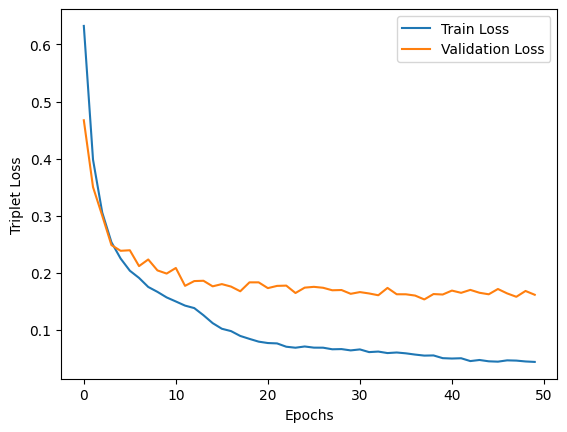

In [ ]:
plt.plot(history['train'], label='Train Loss')
plt.plot(history['val'], label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Triplet Loss')
plt.legend()

## 5. Evaluate Model Performance

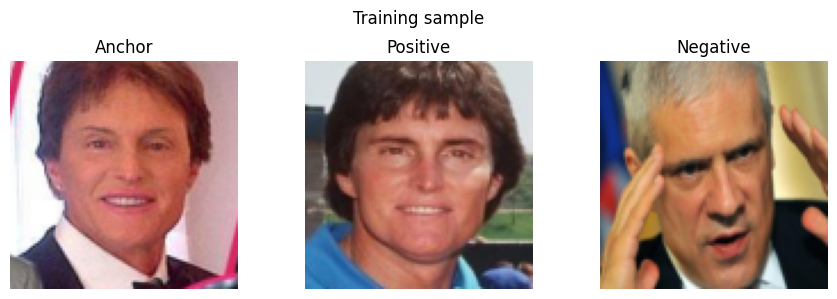

In [114]:
batch = val_ds[np.random.randint(0, len(val_ds)-1)]

fig, axes = plt.subplots(1, 3, figsize=(9, 3))
for i, img in enumerate(batch):
    axes[i].imshow(img.permute((1, 2, 0)))
    axes[i].axis(False)

axes[0].set_title('Anchor')
axes[1].set_title('Positive')
axes[2].set_title('Negative')

plt.suptitle('Training sample')
plt.tight_layout()
plt.show()

In [116]:
_a = batch[0].to(device)
_p = batch[1].to(device)
_n = batch[2].to(device)
z_anchor, z_positive, z_negative = model(_a.unsqueeze(0), _p.unsqueeze(0), _n.unsqueeze(0))
dist_ap = euclidean_distance(z_anchor, z_positive)
dist_an = euclidean_distance(z_anchor, z_negative)

print(dist_ap)
print(dist_an)

tensor([6.6952], device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor([10.1805], device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


In [ ]:
# import dill

# dill.dump_session('notebook.dill')

## 6. Real Time Predictions